# Cryptocurrency Forecasting using LSTMs

In [32]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from pylab import rcParams
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import keras
from keras.layers import Dropout, Bidirectional, CuDNNLSTM, Dense, Activation

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [33]:
# Google Spreadsheet ID
SHEET_ID = '1elqgsyy7aLDTo9Cd1eyqZRoB9tuSJqepeY4vMLOxxvg' # Cryptocurrency

# BTC-IDR

## Data Overview
From Google Finance

In [34]:
url = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/gviz/tq?tqx=out:csv&sheet=BTC/IDR'
df = pd.read_csv(url, parse_dates=['Date'])
df = df.sort_values('Date')
df.head()

,Date,Close
0,01/01/2019 23:58:00,55325406.0
365,01/01/2020 23:58:00,99715037.2
731,01/01/2021 23:58:00,417716185.8
1096,01/01/2022 23:58:00,679819082.8
1461,01/01/2023 23:58:00,258018346.3


Text(0, 0.5, 'Close Price (USD)')

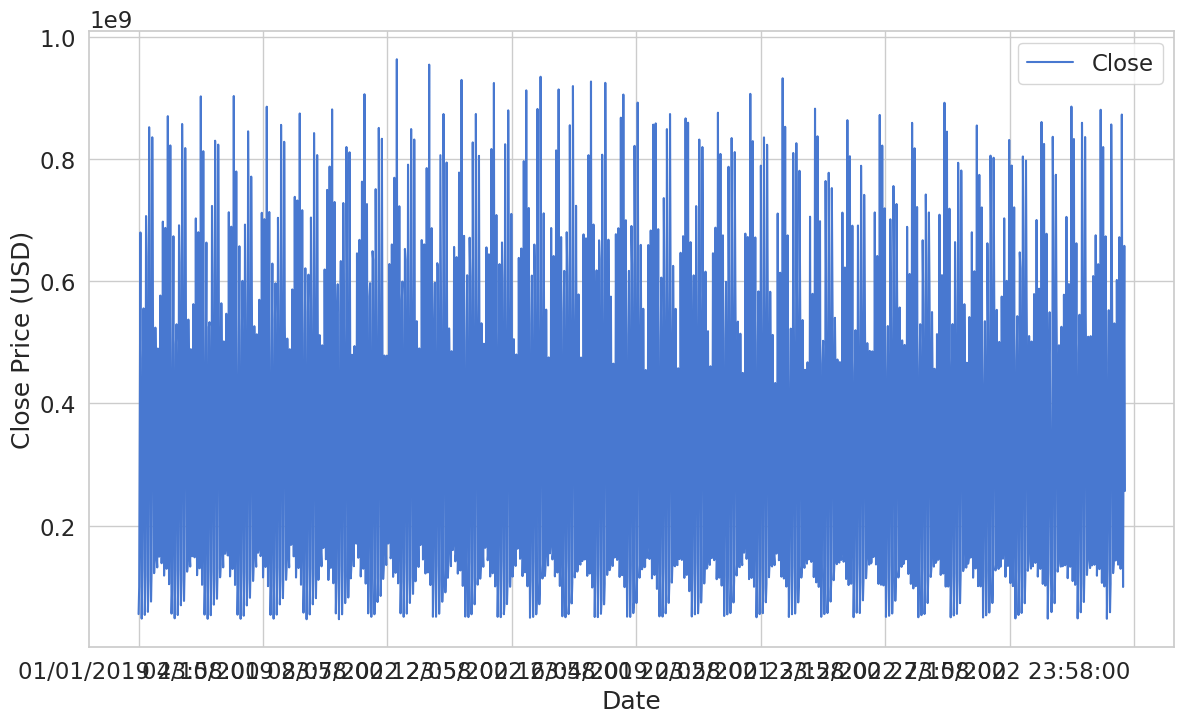

In [35]:
ax = df.plot(x='Date', y='Close')
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

## Normalization

In [36]:
scaler = MinMaxScaler()
close_price = df.Close.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)
scaled_close.shape

(1586, 1)

## Data preprocessing

In [37]:
scaler = MinMaxScaler()
close_price = df.Close.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)

In [38]:
scaled_close = scaled_close[~np.isnan(scaled_close)]
scaled_close = scaled_close.reshape(-1, 1)

## Making sequences

In [39]:
SEQ_LEN = 100
def to_sequences(data, seq_len):
    d = []
    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])
    return np.array(d)
def preprocess(data_raw, seq_len, train_split):
    data = to_sequences(data_raw, seq_len)
    num_train = int(train_split * data.shape[0])
    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]
    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]
    return X_train, y_train, X_test, y_test
X_train, y_train, X_test, y_test =\
 preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [40]:
X_train.shape

(1411, 99, 1)

In [41]:
X_test.shape

(75, 99, 1)

## Building LSTM model

In [42]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1
model = keras.Sequential()

model.add(Bidirectional(
  CuDNNLSTM(WINDOW_SIZE, return_sequences=True),
  input_shape=(WINDOW_SIZE, X_train.shape[-1])
))
model.add(Dropout(rate=DROPOUT))
model.add(Bidirectional(
  CuDNNLSTM((WINDOW_SIZE * 2), return_sequences=True)
))
model.add(Dropout(rate=DROPOUT))
model.add(Bidirectional(
  CuDNNLSTM(WINDOW_SIZE, return_sequences=False)
))
model.add(Dense(units=1))
model.add(Activation('linear'))

## Training

In [43]:
BATCH_SIZE = 64
model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=BATCH_SIZE,
    shuffle=False,
    validation_split=0.1
)

Epoch 1/50
20/20 [==============================] - 7s 103ms/step - loss: 0.0808 - val_loss: 0.0672
Epoch 2/50
20/20 [==============================] - 1s 68ms/step - loss: 0.0699 - val_loss: 0.0653
Epoch 3/50
20/20 [==============================] - 1s 67ms/step - loss: 0.0663 - val_loss: 0.0592
Epoch 4/50
20/20 [==============================] - 1s 74ms/step - loss: 0.0619 - val_loss: 0.0567
Epoch 5/50
20/20 [==============================] - 1s 68ms/step - loss: 0.0569 - val_loss: 0.0513
Epoch 6/50
20/20 [==============================] - 1s 69ms/step - loss: 0.0511 - val_loss: 0.0458
Epoch 7/50
20/20 [==============================] - 1s 69ms/step - loss: 0.0433 - val_loss: 0.0426
Epoch 8/50
20/20 [==============================] - 1s 73ms/step - loss: 0.0371 - val_loss: 0.0273
Epoch 9/50
20/20 [==============================] - 1s 70ms/step - loss: 0.0323 - val_loss: 0.0274
Epoch 10/50
20/20 [==============================] - 1s 65ms/step - loss: 0.0276 - val_loss: 0.0256
Epoch 11

In [44]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 22ms/step - loss: 0.0178


0.017765609547495842

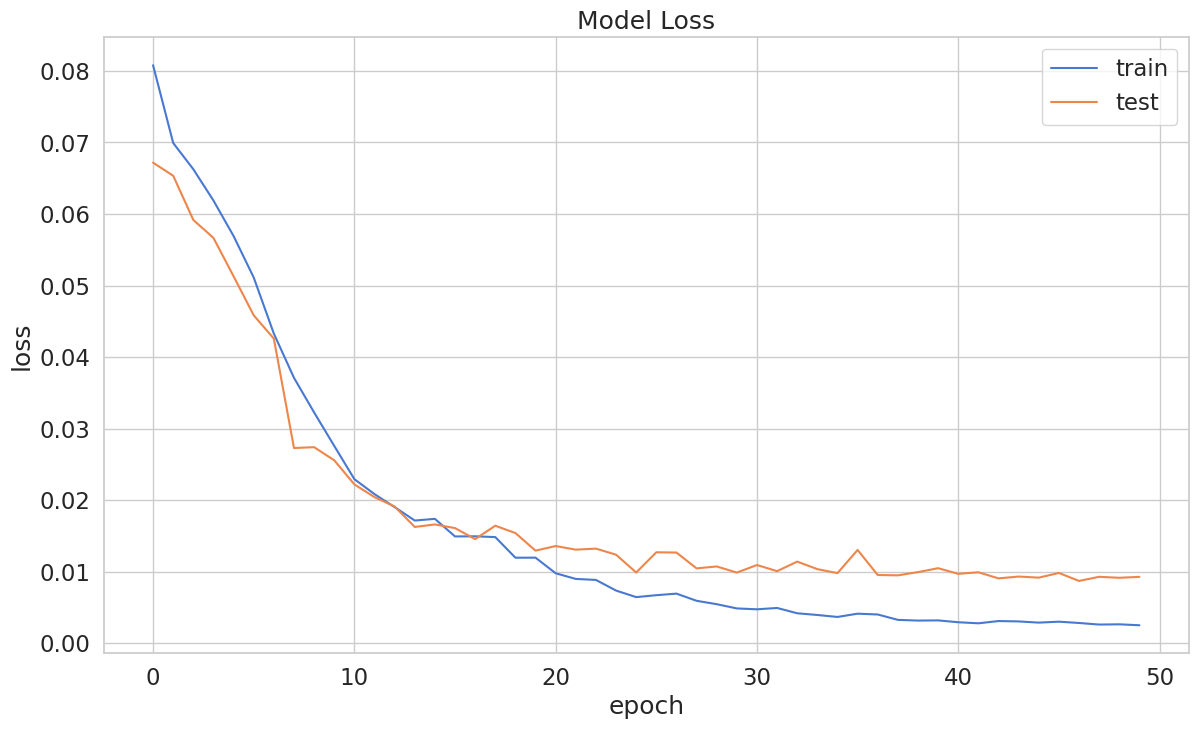

In [45]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

## Prediction

3/3 [==============================] - 1s 15ms/step


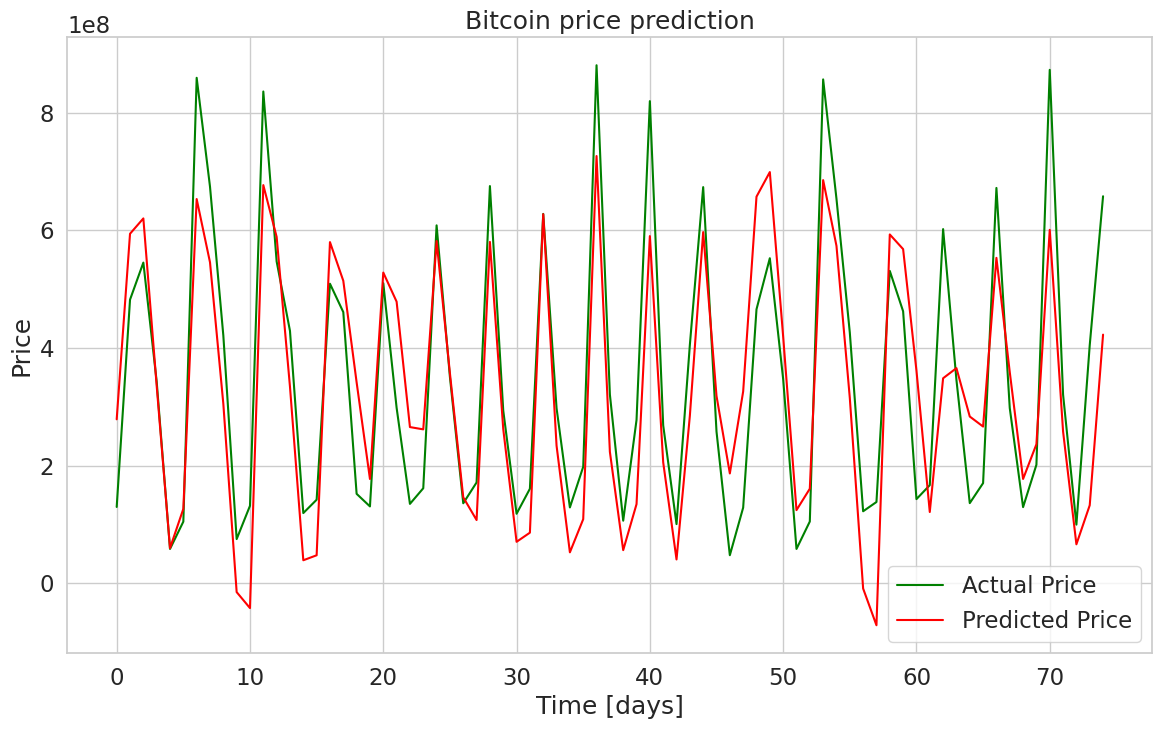

In [46]:
y_hat = model.predict(X_test)
y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show()

# ADA-IDR

## Data Overview
From Google Finance

In [47]:
url = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/gviz/tq?tqx=out:csv&sheet=ADA/IDR'
df = pd.read_csv(url, parse_dates=['Date'])
df = df.sort_values('Date')
df.head()

,Date,Close
0,01/01/2019 23:58:00,611.920174
363,01/01/2020 23:58:00,456.208501
727,01/01/2021 23:58:00,2456.917817
1092,01/01/2022 23:58:00,19613.173000
1457,01/01/2023 23:58:00,3879.683247


Text(0, 0.5, 'Close Price (USD)')

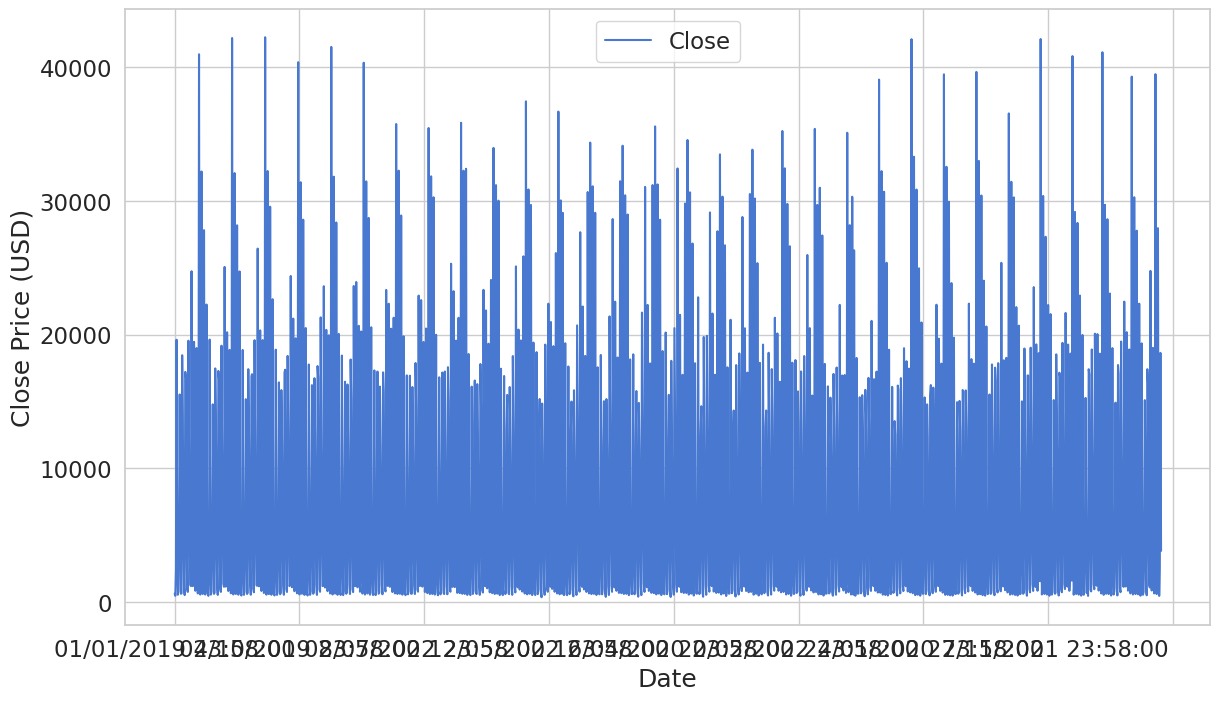

In [48]:
ax = df.plot(x='Date', y='Close')
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

## Normalization

In [49]:
scaler = MinMaxScaler()
close_price = df.Close.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)
scaled_close.shape

(1582, 1)

## Data preprocessing

In [50]:
scaler = MinMaxScaler()
close_price = df.Close.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)

In [51]:
scaled_close = scaled_close[~np.isnan(scaled_close)]
scaled_close = scaled_close.reshape(-1, 1)

## Making sequences

In [52]:
SEQ_LEN = 100
def to_sequences(data, seq_len):
    d = []
    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])
    return np.array(d)
def preprocess(data_raw, seq_len, train_split):
    data = to_sequences(data_raw, seq_len)
    num_train = int(train_split * data.shape[0])
    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]
    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]
    return X_train, y_train, X_test, y_test
X_train, y_train, X_test, y_test =\
 preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [53]:
X_train.shape

(1407, 99, 1)

In [54]:
X_test.shape

(75, 99, 1)

## Building LSTM model

In [55]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1
model = keras.Sequential()

model.add(Bidirectional(
  CuDNNLSTM(WINDOW_SIZE, return_sequences=True),
  input_shape=(WINDOW_SIZE, X_train.shape[-1])
))
model.add(Dropout(rate=DROPOUT))
model.add(Bidirectional(
  CuDNNLSTM((WINDOW_SIZE * 2), return_sequences=True)
))
model.add(Dropout(rate=DROPOUT))
model.add(Bidirectional(
  CuDNNLSTM(WINDOW_SIZE, return_sequences=False)
))
model.add(Dense(units=1))
model.add(Activation('linear'))

## Training

In [56]:
BATCH_SIZE = 64
model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=BATCH_SIZE,
    shuffle=False,
    validation_split=0.1
)

Epoch 1/50
20/20 [==============================] - 6s 97ms/step - loss: 0.0524 - val_loss: 0.0509
Epoch 2/50
20/20 [==============================] - 1s 69ms/step - loss: 0.0463 - val_loss: 0.0455
Epoch 3/50
20/20 [==============================] - 1s 70ms/step - loss: 0.0398 - val_loss: 0.0405
Epoch 4/50
20/20 [==============================] - 1s 69ms/step - loss: 0.0331 - val_loss: 0.0630
Epoch 5/50
20/20 [==============================] - 1s 69ms/step - loss: 0.0404 - val_loss: 0.0394
Epoch 6/50
20/20 [==============================] - 1s 67ms/step - loss: 0.0313 - val_loss: 0.0379
Epoch 7/50
20/20 [==============================] - 1s 69ms/step - loss: 0.0265 - val_loss: 0.0347
Epoch 8/50
20/20 [==============================] - 1s 70ms/step - loss: 0.0255 - val_loss: 0.0355
Epoch 9/50
20/20 [==============================] - 1s 68ms/step - loss: 0.0202 - val_loss: 0.0338
Epoch 10/50
20/20 [==============================] - 1s 72ms/step - loss: 0.0167 - val_loss: 0.0309
Epoch 11/

In [57]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 20ms/step - loss: 0.0104


0.010437259450554848

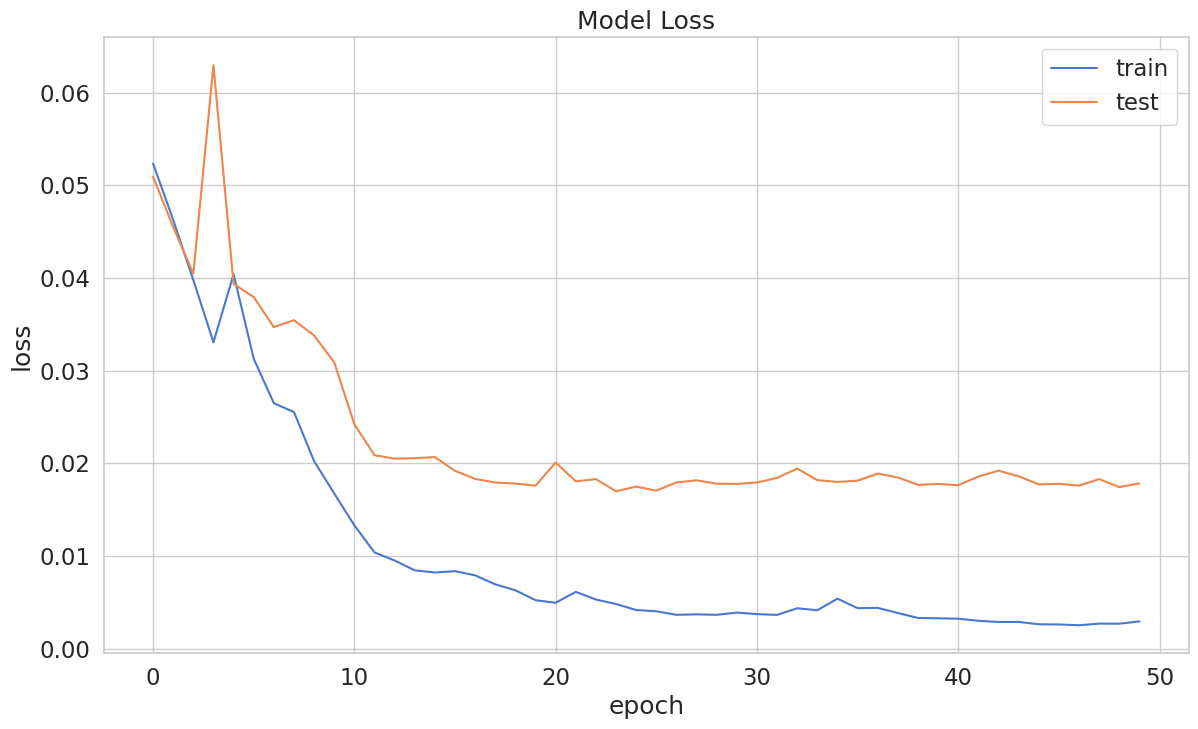

In [58]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

## Prediction

3/3 [==============================] - 0s 21ms/step


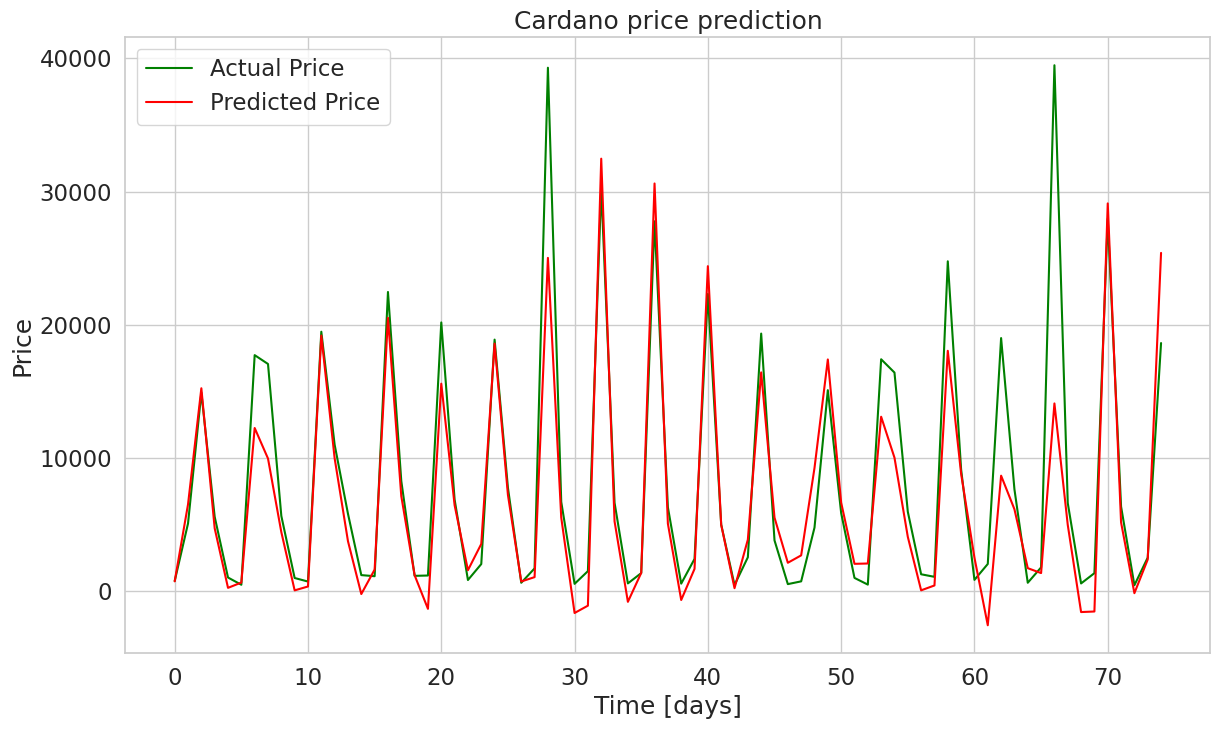

In [59]:
y_hat = model.predict(X_test)
y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Cardano price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show()

# ETH-IDR

## Data Overview
From Google Finance

In [60]:
url = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/gviz/tq?tqx=out:csv&sheet=ETH/IDR'
df = pd.read_csv(url, parse_dates=['Date'])
df = df.sort_values('Date')
df.head()

,Date,Close
0,01/01/2019 23:58:00,2.020785e+06
365,01/01/2020 23:58:00,1.809788e+06
731,01/01/2021 23:58:00,1.039007e+07
1096,01/01/2022 23:58:00,5.365730e+07
1461,01/01/2023 23:58:00,1.864496e+07


Text(0, 0.5, 'Close Price (USD)')

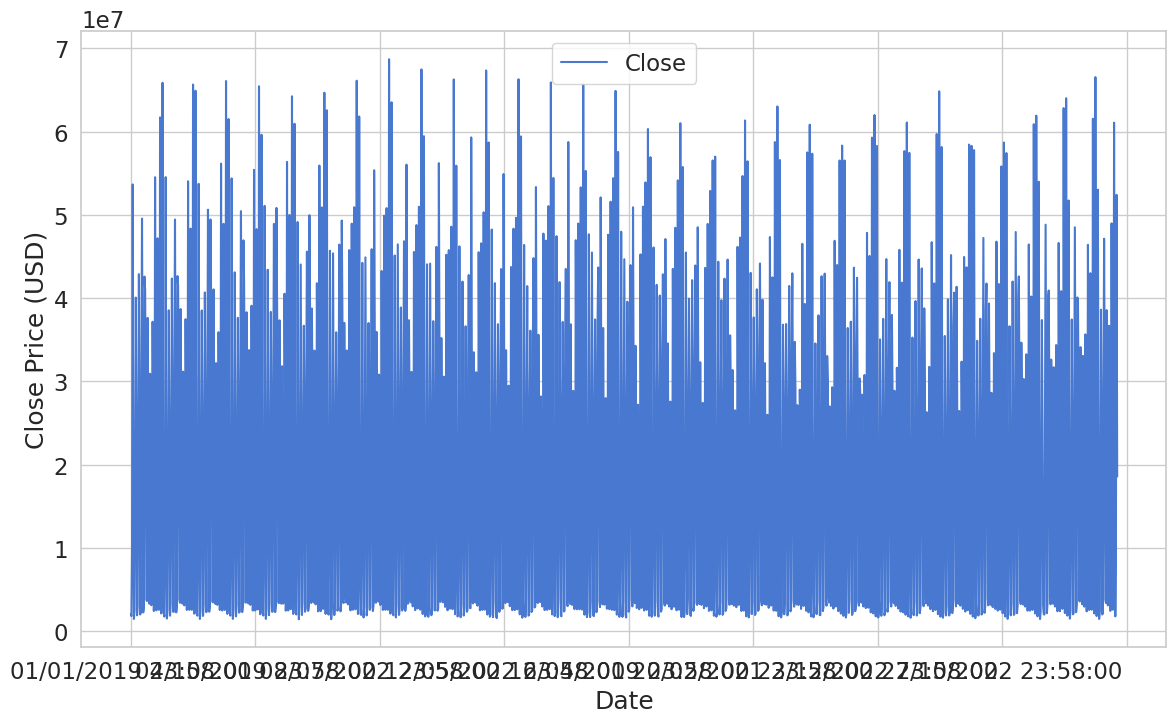

In [61]:
ax = df.plot(x='Date', y='Close')
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

## Normalization

In [62]:
scaler = MinMaxScaler()
close_price = df.Close.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)
scaled_close.shape

(1586, 1)

## Data preprocessing

In [63]:
scaler = MinMaxScaler()
close_price = df.Close.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)

In [64]:
scaled_close = scaled_close[~np.isnan(scaled_close)]
scaled_close = scaled_close.reshape(-1, 1)

## Making sequences

In [65]:
SEQ_LEN = 100
def to_sequences(data, seq_len):
    d = []
    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])
    return np.array(d)
def preprocess(data_raw, seq_len, train_split):
    data = to_sequences(data_raw, seq_len)
    num_train = int(train_split * data.shape[0])
    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]
    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]
    return X_train, y_train, X_test, y_test
X_train, y_train, X_test, y_test =\
 preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [66]:
X_train.shape

(1411, 99, 1)

In [67]:
X_test.shape

(75, 99, 1)

## Building LSTM model

In [68]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1
model = keras.Sequential()

model.add(Bidirectional(
  CuDNNLSTM(WINDOW_SIZE, return_sequences=True),
  input_shape=(WINDOW_SIZE, X_train.shape[-1])
))
model.add(Dropout(rate=DROPOUT))
model.add(Bidirectional(
  CuDNNLSTM((WINDOW_SIZE * 2), return_sequences=True)
))
model.add(Dropout(rate=DROPOUT))
model.add(Bidirectional(
  CuDNNLSTM(WINDOW_SIZE, return_sequences=False)
))
model.add(Dense(units=1))
model.add(Activation('linear'))

## Training

In [69]:
BATCH_SIZE = 64
model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=BATCH_SIZE,
    shuffle=False,
    validation_split=0.1
)

Epoch 1/50
20/20 [==============================] - 6s 89ms/step - loss: 0.0790 - val_loss: 0.0684
Epoch 2/50
20/20 [==============================] - 1s 68ms/step - loss: 0.0694 - val_loss: 0.0651
Epoch 3/50
20/20 [==============================] - 1s 68ms/step - loss: 0.0637 - val_loss: 0.0580
Epoch 4/50
20/20 [==============================] - 1s 73ms/step - loss: 0.0522 - val_loss: 0.0482
Epoch 5/50
20/20 [==============================] - 1s 72ms/step - loss: 0.0465 - val_loss: 0.0457
Epoch 6/50
20/20 [==============================] - 1s 73ms/step - loss: 0.0465 - val_loss: 0.0392
Epoch 7/50
20/20 [==============================] - 1s 72ms/step - loss: 0.0437 - val_loss: 0.0362
Epoch 8/50
20/20 [==============================] - 1s 73ms/step - loss: 0.0450 - val_loss: 0.0410
Epoch 9/50
20/20 [==============================] - 2s 77ms/step - loss: 0.0436 - val_loss: 0.0425
Epoch 10/50
20/20 [==============================] - 2s 75ms/step - loss: 0.0391 - val_loss: 0.0305
Epoch 11/

In [70]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 16ms/step - loss: 0.0119


0.011897037737071514

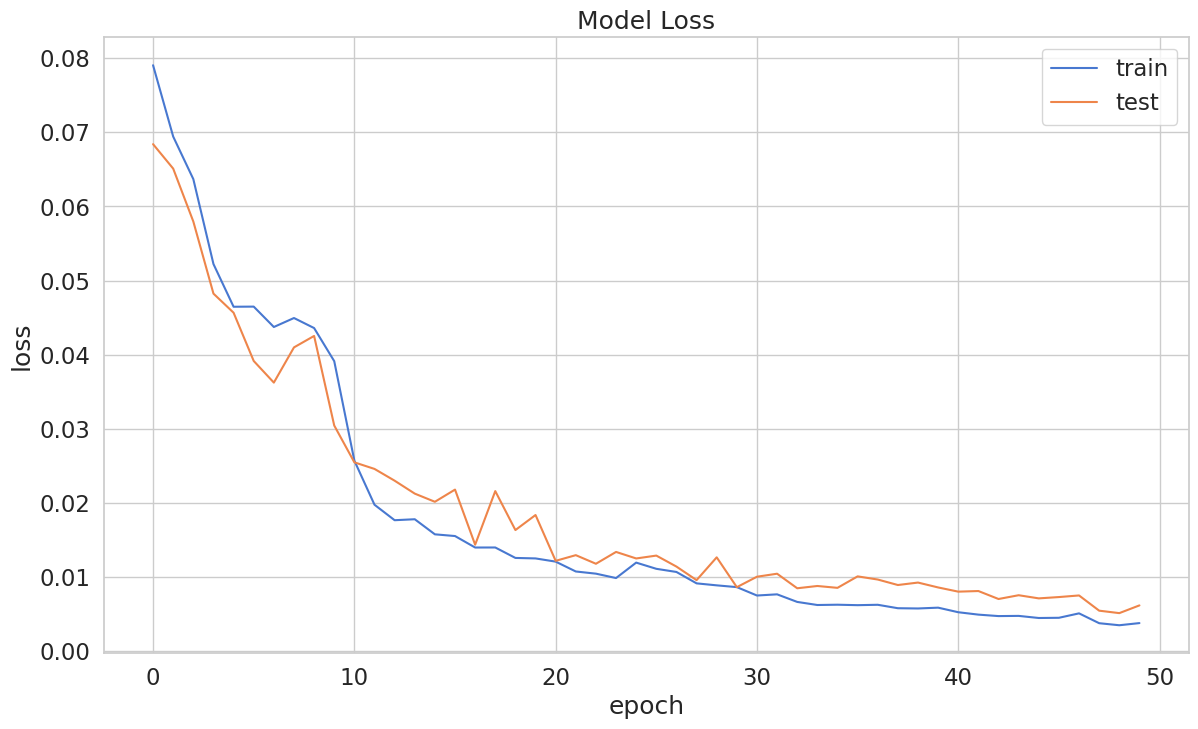

In [71]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

## Prediction

3/3 [==============================] - 0s 14ms/step


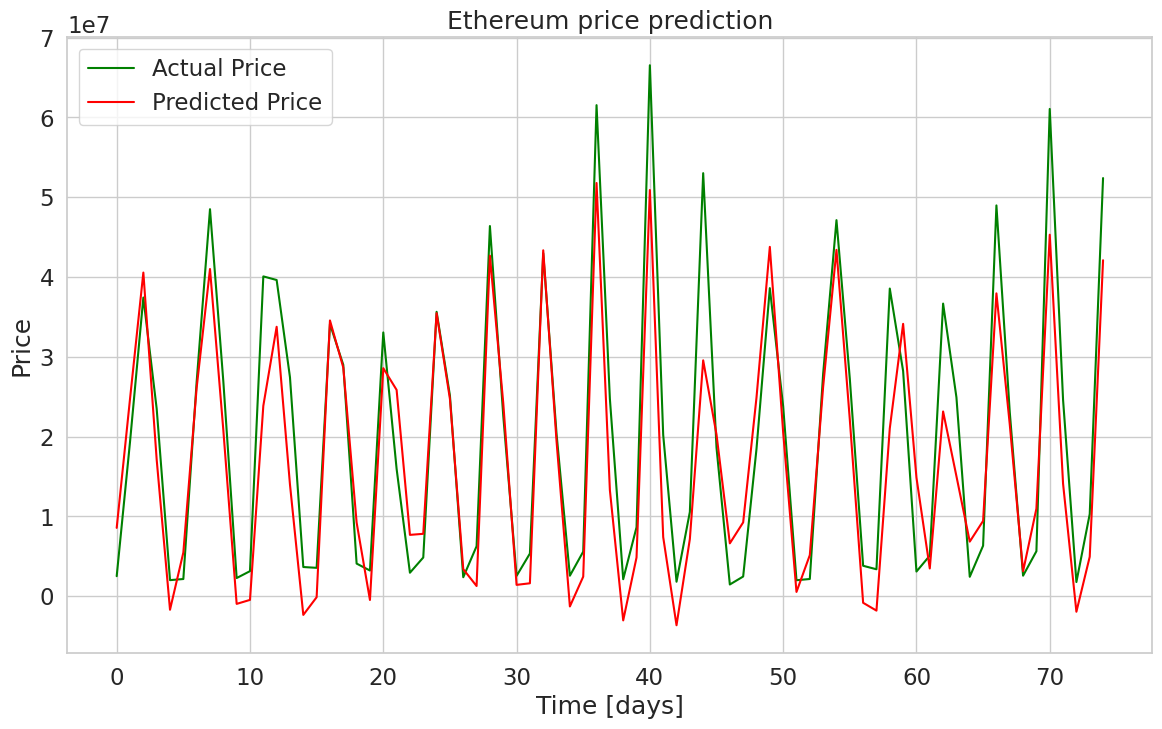

In [72]:
y_hat = model.predict(X_test)
y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Ethereum price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show()